# Experiments Theory of Mind in teacher-learner gridworld setup 
## Deep Neural Network models

In [1]:
from __future__ import annotations
import warnings

from minigrid.core.actions import Actions
from minigrid.core.constants import IDX_TO_COLOR, DIR_TO_VEC

import numpy as np
import pickle
import json
import matplotlib.pyplot as plt
from tqdm import trange, tqdm

from IPython.display import clear_output

from environment import MultiGoalsEnv, MultiRoomsGoalsEnv 
from learner import BayesianLearner
from utils import *
from utils_viz import *

from neural_network_ToM.model import CharNet, MentalNet, PredNet
from neural_network_ToM.storage import Storage
from neural_network_ToM.dataset import preprocess_data, ToMNetDataset

warnings.filterwarnings("ignore", category=RuntimeWarning)

pygame 2.4.0 (SDL 2.26.4, Python 3.11.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Display

In [13]:
grid_size = 15
grid_size_demo = 45

max_length_obs = grid_size*grid_size
max_length_demo_eval = grid_size_demo*grid_size_demo//2

train_storage = Storage('dataset_07.27.2023',
                    data_mode='train',
                    max_length_obs=max_length_obs,
                    max_length_demo_eval=max_length_demo_eval)
train_data = train_storage.extract()
train_dataset = ToMNetDataset(**train_data)

val_storage = Storage('dataset_07.27.2023',
                    data_mode='val',
                    max_length_obs=max_length_obs,
                    max_length_demo_eval=max_length_demo_eval)
val_data = val_storage.extract()
val_dataset = ToMNetDataset(**val_data)

test_storage = Storage('dataset_07.27.2023',
                    data_mode='test',
                    max_length_obs=max_length_obs,
                    max_length_demo_eval=max_length_demo_eval)
test_data = test_storage.extract()
test_dataset = ToMNetDataset(**test_data)

In [18]:
obs_length = []
demo_eval_length = []
n = 0

for dataset in [train_data, val_data, test_data]:
    for data_path in dataset['data_paths']:
        data_list, next_action, query_state = pickle.load(open(data_path, 'rb'))

        obs = data_list[0]
        demo, actions_demo = data_list[1]
        eval, actions_eval = data_list[2]
        demo_eval = (demo + eval, actions_demo + actions_eval)

        obs_length.append(len(obs[0]))
        demo_eval_length.append(len(demo+eval))
        n += 1

In [20]:
mean_length_obs = np.sum(obs_length) / n
mean_length_demo_eval = np.sum(demo_eval_length) / n

print(f'Mean length of observation: {mean_length_obs:.4f}')
print(f'Mean length of demonstration + evaluation: {mean_length_demo_eval:.4f}')

Mean length of observation: 56.8073
Mean length of demonstration + evaluation: 253.3542


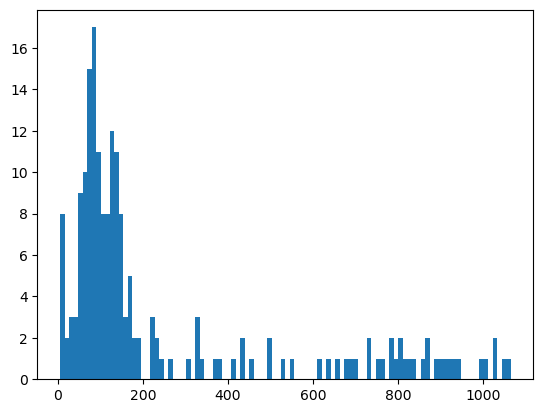

In [23]:
plt.hist(demo_eval_length, bins=100);

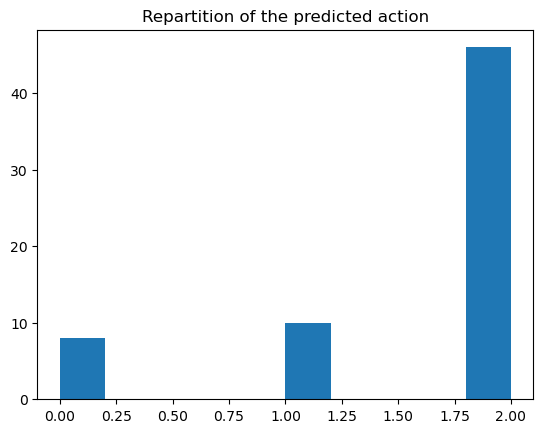

In [25]:
actions = []
for ii, data in enumerate(test_dataset):
    obs, demo_eval, state, a = data
    actions.append(a)

plt.hist(actions)
plt.title('Repartition of the predicted action');

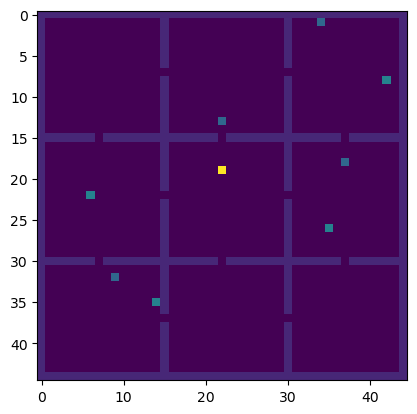

In [9]:
plt.imshow(train_dataset[0][1][25,:,:,0].T)

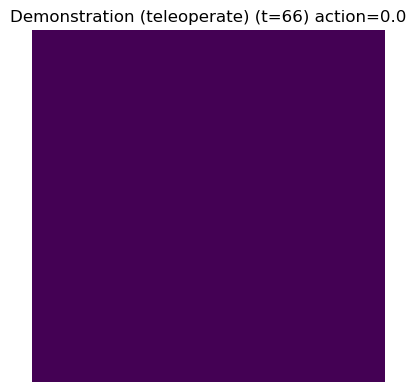

In [5]:
phases = ['Observation', 'Demonstration (teleoperate)', 'Evaluation']

for kk, data in enumerate(train_dataset[0][:2]):
    for ii, frame in enumerate(data):
        fig = plt.figure(figsize=(10,5))
        fig.add_subplot(1,2,1)
        plt.imshow(frame[:,:,0].T)
        plt.title(f'{phases[kk]} (t={ii}) action={frame[0,0,3]}')
        plt.axis('off')

        clear_output(wait=True)
        plt.show()
        plt.pause(0.1)
        if np.all( frame == 0):
            break

In [24]:
1012*45*45*32

65577600

# Debug model

In [10]:
import torch.nn as nn
import torch as torch

device = 'cpu'

In [11]:
e_char = CharNet(num_input=4, num_step=max_length_obs, num_output=32, grid_size=15, device=device)(torch.Tensor(dataset[0][0][None, None, ...]).to(device))
print(e_char.shape)

obs torch.Size([1, 1, 225, 15, 15, 4])
obs past torch.Size([1, 225, 4, 15, 15]) [batch, num_step, channel, H, W]
obs_past torch.Size([225, 4, 15, 15]) [batch * num_step, channel, H, W]
x torch.Size([225, 32, 1, 1])
 outs torch.Size([1, 225, 64]) [batch, num_step, output]
outs torch.Size([1, 225, 64]) [batch, num_step, output]
outs torch.Size([1, 14400]) [batch, num_step * output]
torch.Size([1, 32])


In [12]:
e_mental = MentalNet(num_input=4, num_step=max_length_demo_eval, num_output=32, device=device)(torch.Tensor(dataset[0][1][None, ...]).to(device))

obs torch.Size([1, 1012, 45, 45, 4]) [batch, num_step, H, W, channel]
obs torch.Size([1, 1012, 4, 45, 45]) [batch, num_step, channel, H, W]
obs torch.Size([1012, 4, 45, 45]) [num_step * batch, channel, H, W]


: 

: 

In [10]:
e_char_concat = e_char[..., None, None]
e_char_concat = e_char_concat.repeat(1, 1, 45, 45)
e_char_concat.shape

torch.Size([1, 32, 45, 45])

In [11]:
e_mental_concat = e_mental
print(e_mental_concat.shape)

torch.Size([1, 32, 45, 45])


In [13]:
query_state = torch.tensor(dataset[0][2])
query_state_concat = query_state[None, ...]
query_state_concat = query_state_concat.permute(0, 3, 1, 2)
print(query_state_concat.shape)

torch.Size([1, 3, 45, 45])


In [33]:
torch.concatenate([e_char_concat, e_mental_concat, query_state_concat], axis=1).shape

torch.Size([1, 65, 45, 45, 3])

In [8]:
past_traj = torch.Tensor(dataset[0][0][None, None, ...]).to(device)
current_traj = torch.Tensor(dataset[0][1][None, ...]).to(device)
query_state = torch.Tensor(dataset[0][2][None, ...]).to(device)

In [9]:
pred_policy = PredNet(num_input=4,
                        num_step_obs=max_length_obs,
                        num_steps_demo_eval=max_length_demo+max_length_eval,
                        grid_size_demo=grid_size_demo,
                        grid_size_obs=grid_size,
                        device='cpu')(past_traj, current_traj, query_state)

obs torch.Size([1, 1, 225, 15, 15, 4])
obs past torch.Size([1, 225, 4, 15, 15]) [batch, num_step, channel, H, W]
obs_past torch.Size([225, 4, 15, 15]) [batch * num_step, channel, H, W]
x torch.Size([225, 32, 1, 1])
 outs torch.Size([1, 225, 64]) [batch, num_step, output]
outs torch.Size([1, 225, 64]) [batch, num_step, output]
outs torch.Size([1, 14400]) [batch, num_step * output]
echar after model torch.Size([1, 8])
echar after model torch.Size([1, 8])
obs torch.Size([1, 379, 45, 45, 4]) [batch, num_step, H, W, channel]
obs torch.Size([1, 379, 4, 45, 45]) [batch, num_step, channel, H, W]
obs torch.Size([379, 4, 45, 45]) [num_step * batch, channel, H, W]
x torch.Size([379, 32, 45, 45]) [batch * num_step, output, H, W]
x torch.Size([1, 379, 32, 45, 45]) [batch, num_step, output, H, W]
outs torch.Size([1, 379, 32, 45, 45]) ??
mask torch.Size([1, 379])
tensor(True)
final shape torch.Size([1, 32, 45, 45])
torch.Size([1, 8, 45, 45]) torch.Size([1, 32, 45, 45]) torch.Size([1, 3, 45, 45])
